In [1]:
import pandas as pd

ndvi = pd.read_csv("../data/processed/Bihar_Block_NDVI.csv")
rain = pd.read_csv("../data/processed/Bihar_Block_Rainfall.csv")
et   = pd.read_csv("../data/processed/Bihar_Block_ET.csv")

print(ndvi.shape, rain.shape, et.shape)


(82524, 7) (43056, 7) (109434, 7)


In [2]:
ndvi = ndvi.rename(columns={"mean": "NDVI"})
rain = rain.rename(columns={"mean": "Rainfall"})
et   = et.rename(columns={"mean": "ET"})

ndvi = ndvi[["block_id", "year", "month", "NDVI"]]
rain = rain[["block_id", "year", "month", "Rainfall"]]
et   = et[["block_id", "year", "month", "ET"]]


In [3]:
lookup = (
    ndvi[["block_id"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

lookup["block_uid"] = lookup.index

lookup.head()


,block_id,block_uid
0,117,0
1,97,1
2,452,2
3,513,3
4,104,4


In [4]:
ndvi = ndvi.merge(lookup, on="block_id", how="left")
rain = rain.merge(lookup, on="block_id", how="left")
et   = et.merge(lookup,   on="block_id", how="left")


In [5]:
ndvi_monthly = (
    ndvi
    .groupby(["block_uid", "year", "month"], as_index=False)
    .agg(NDVI=("NDVI", "mean"))
)

et_monthly = (
    et
    .groupby(["block_uid", "year", "month"], as_index=False)
    .agg(ET=("ET", "mean"))
)

df = (
    ndvi_monthly
    .merge(rain[["block_uid", "year", "month", "Rainfall"]],
           on=["block_uid", "year", "month"], how="left")
    .merge(et_monthly,
           on=["block_uid", "year", "month"], how="left")
)

df.head()


,block_uid,year,month,NDVI,Rainfall,ET
0,0,2019,1,0.476935,10.515435,NaN
1,0,2019,2,0.646473,35.423764,NaN
2,0,2019,3,0.488537,23.605506,NaN
3,0,2019,4,0.349508,57.145763,NaN
4,0,2019,5,0.312552,47.192778,NaN


In [6]:
et.groupby("year").size()


year
2021    27508
2022    26910
2023    27508
2024    27508
dtype: int64

In [7]:
df = df[df["year"] >= 2021].reset_index(drop=True)


In [8]:
df.isna().sum()


block_uid    0
year         0
month        0
NDVI         0
Rainfall     0
ET           0
dtype: int64

In [9]:
df = df.sort_values(["block_uid", "year", "month"]).reset_index(drop=True)


In [10]:
df["rain_1m"] = df["Rainfall"]


In [11]:
df["rain_3m"] = (
    df.groupby("block_uid")["Rainfall"]
      .rolling(3)
      .sum()
      .reset_index(0, drop=True)
)


In [12]:
df["rain_6m"] = (
    df.groupby("block_uid")["Rainfall"]
      .rolling(6)
      .sum()
      .reset_index(0, drop=True)
)


In [13]:
df["rain_anomaly"] = (
    df["Rainfall"]
    - df.groupby(["block_uid", "month"])["Rainfall"].transform("mean")
)


In [14]:
df["ndvi_change"] = (
    df.groupby("block_uid")["NDVI"]
      .diff()
)


In [15]:
df["ndvi_anomaly"] = (
    df["NDVI"]
    - df.groupby(["block_uid", "month"])["NDVI"].transform("mean")
)


In [34]:
df["water_surplus"] = df["Rainfall"] - df["ET"]


In [35]:
df["flood_pressure"] = (
    0.4 * df["rain_3m"] +
    0.3 * df["rain_anomaly"] +
    0.2 * df["water_surplus"] -
    0.1 * df["ndvi_anomaly"]
)


In [36]:
df = df.dropna().reset_index(drop=True)


In [37]:
df.head()



,block_uid,year,month,NDVI,Rainfall,ET,rain_1m,rain_3m,rain_6m,rain_anomaly,ndvi_change,ndvi_anomaly,water_surplus,et_rain_ratio,recharge_deficit,et_3m,recharge_deficit_6m,ndvi_et_ratio,gw_stress_index,flood_pressure
0,0,2021,11,0.424953,0.000000,10.600570,0.000000,370.725448,1681.889232,-0.046164,-0.242986,-0.012264,-10.600570,10600.570479,-10.600570,21.648407,1543.727087,0.040084,3717.711360,146.157442
1,0,2021,12,0.378147,17.272919,5.881513,17.272919,117.946292,1230.193860,11.463174,-0.046807,0.017870,11.391407,0.340485,11.391407,13.387166,1103.432095,0.064283,-0.623499,52.893963
2,0,2022,1,0.628672,11.995909,8.620495,11.995909,29.268829,750.968778,4.345995,0.250526,0.152375,3.375414,0.718560,3.375414,8.367526,640.540795,0.072919,0.889521,13.671175
3,0,2022,2,0.678177,20.267430,13.764602,20.267430,49.536259,420.261707,12.772019,0.049505,0.059241,6.502829,0.679115,6.502829,9.422203,327.049877,0.049266,0.162396,24.940751
4,0,2022,3,0.523728,12.713479,6.241775,12.713479,44.976818,162.923110,-9.495094,-0.154449,0.036673,6.471704,0.490919,6.471704,9.542291,94.134739,0.083893,0.133268,16.432873


In [38]:
df = df.sort_values(["block_uid", "year", "month"]).reset_index(drop=True)


In [39]:
df["et_rain_ratio"] = df["ET"] / (df["Rainfall"] + 1e-3)


In [40]:
df["recharge_deficit"] = df["Rainfall"] - df["ET"]


In [41]:
df["et_3m"] = (
    df.groupby("block_uid")["ET"]
      .rolling(3)
      .mean()
      .reset_index(0, drop=True)
)


In [42]:
df["recharge_deficit_6m"] = (
    df.groupby("block_uid")["recharge_deficit"]
      .rolling(6)
      .sum()
      .reset_index(0, drop=True)
)


In [43]:
df["ndvi_et_ratio"] = df["NDVI"] / (df["ET"] + 1e-3)


In [44]:
df["ndvi_anomaly"] = (
    df["NDVI"]
    - df.groupby(["block_uid", "month"])["NDVI"].transform("mean")
)


In [45]:
df["gw_stress_index"] = (
    0.35 * df["et_rain_ratio"] +
    0.30 * (-df["recharge_deficit"]) +
    0.20 * df["et_3m"] -
    0.15 * df["ndvi_anomaly"]
)


In [46]:
df = df.dropna().reset_index(drop=True)


In [47]:
flood_features = [
    "rain_1m",
    "rain_3m",
    "rain_6m",
    "rain_anomaly",
    "ndvi_change",
    "ndvi_anomaly",
    "water_surplus"
]


In [48]:
gw_features = [
    "et_rain_ratio",
    "recharge_deficit",
    "et_3m",
    "recharge_deficit_6m",
    "ndvi_et_ratio",
    "ndvi_anomaly"
]


In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


In [50]:
target_flood = "flood_pressure"
Xf = df[flood_features]
yf = df[target_flood]

Xf_train, Xf_test, yf_train, yf_test = train_test_split(
    Xf, yf, test_size=0.2, random_state=42
)

flood_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)

flood_model.fit(Xf_train, yf_train)


,n_estimators,200
,criterion,'squared_error'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [54]:
# --- TRAIN GROUNDWATER MODEL ---

# 1. Define Target for Groundwater
target_gw = "gw_stress_index"

# 2. Select Features and Target
Xg = df[gw_features]
yg = df[target_gw]

# 3. Split Data (80% Train, 20% Test)
# We use the same random_state=42 for reproducibility
Xg_train, Xg_test, yg_train, yg_test = train_test_split(
    Xg, yg, test_size=0.2, random_state=42
)

# 4. Train Random Forest Regressor
gw_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)

gw_model.fit(Xg_train, yg_train)
print("✅ Groundwater model trained successfully!")

✅ Groundwater model trained successfully!


In [55]:
df[target_flood].describe()


count    19734.000000
mean       135.515355
std        136.553921
min         -7.600474
25%         20.981606
50%         86.912923
75%        229.342016
max        830.909543
Name: flood_pressure, dtype: float64

In [56]:
df[target_gw].describe()

count    19734.000000
mean       329.509729
std        922.128902
min       -231.424391
25%        -49.244640
50%         -7.449236
75%          2.500174
max       6509.285408
Name: gw_stress_index, dtype: float64

In [57]:
import numpy as np

# 1. Create a Log-Transformed Ratio (Stabilizes huge values)
df["log_et_rain_ratio"] = np.log1p(df["et_rain_ratio"])

# 2. Recalculate Groundwater Stress Index with the Log Ratio
df["gw_stress_index"] = (
    0.35 * df["log_et_rain_ratio"] +      # Uses Log scale now (0 to ~10 range)
    0.30 * (-df["recharge_deficit"]) +    # Keeps physical units (mm)
    0.20 * df["et_3m"] -                  # Keeps physical units (mm)
    0.15 * df["ndvi_anomaly"]             # Small unitless value
)

# 3. Check the new stats
print("New GW Stress Stats:")
print(df["gw_stress_index"].describe())


New GW Stress Stats:
count    19734.000000
mean       -24.299337
std         34.109438
min       -231.424531
25%        -49.244992
50%         -7.462551
75%          2.321967
max         14.126108
Name: gw_stress_index, dtype: float64


In [58]:
import shap
print(shap.__version__)
shap.initjs()


0.49.1


 98%|===================| 3875/3947 [00:31<00:00]        

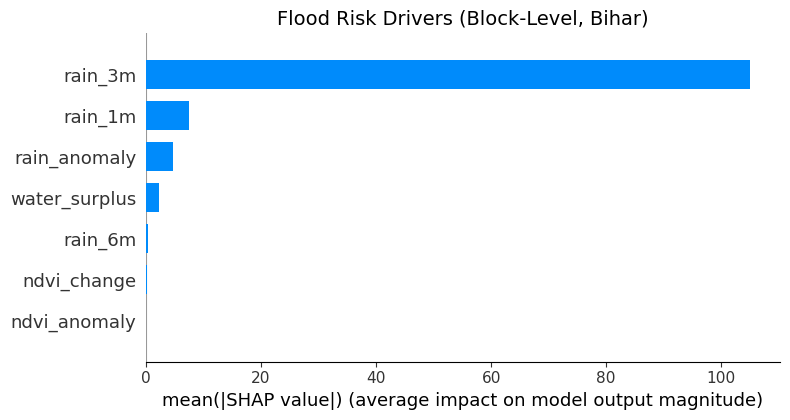

In [53]:
import shap
import matplotlib.pyplot as plt

shap.initjs()

explainer_flood = shap.Explainer(flood_model, Xf_train)
shap_values_flood = explainer_flood(Xf_test)

# SHAP bar plot with title
shap.summary_plot(
    shap_values_flood.values,
    Xf_test,
    plot_type="bar",
    show=False
)

plt.title("Flood Risk Drivers (Block-Level, Bihar)", fontsize=14)
plt.tight_layout()
plt.savefig("flood_shap_bar.png", dpi=300, bbox_inches="tight")
plt.show()


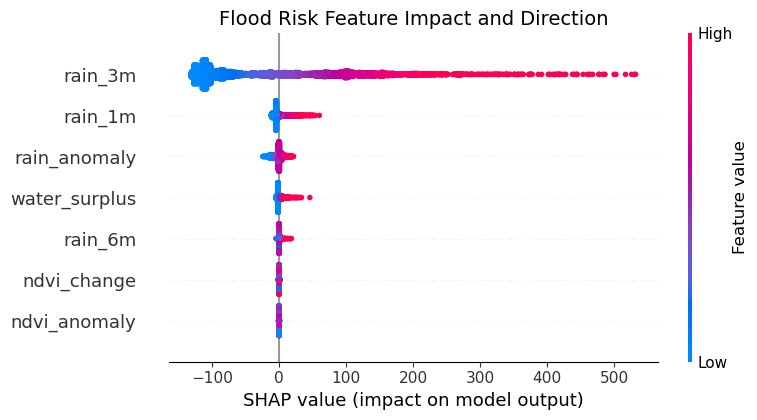

In [59]:
shap.summary_plot(
    shap_values_flood.values,
    Xf_test,
    show=False
)
plt.title("Flood Risk Feature Impact and Direction", fontsize=14)
plt.tight_layout()
plt.savefig("Flood Risk Feature Impact and Direction.png", dpi=300, bbox_inches="tight")
plt.show()


✅ Saved critical plot to: outputs/flood_waterfall_critical_testset.png


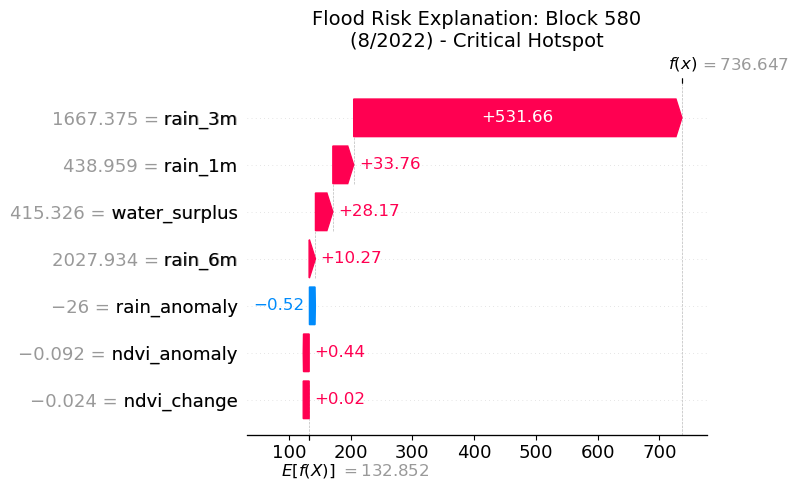

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import os

os.makedirs("outputs", exist_ok=True)

# 1. Find the position of the highest risk row IN THE TEST SET
# We use the model predictions on Xf_test to find the worst case
test_predictions = flood_model.predict(Xf_test)
max_risk_pos = np.argmax(test_predictions)  # This gives a position like 142 (0 to 3946)

# 2. Get the corresponding original index from the main dataframe
# This allows us to look up the Block Name and Date
original_idx = Xf_test.index[max_risk_pos]

# 3. Generate the Waterfall Plot using the position
shap.plots.waterfall(
    shap_values_flood[max_risk_pos],
    show=False
)

# 4. Create the Dynamic Title using the original index
block_name = df.loc[original_idx, "block_name"] if "block_name" in df.columns else f"Block {df.loc[original_idx, 'block_uid']}"
date_label = f"{int(df.loc[original_idx, 'month'])}/{int(df.loc[original_idx, 'year'])}"

plt.title(
    f"Flood Risk Explanation: {block_name}\n({date_label}) - Critical Hotspot",
    fontsize=14
)

plt.tight_layout()

# 5. Save and Show
save_path = f"outputs/flood_waterfall_critical_testset.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
print(f"✅ Saved critical plot to: {save_path}")
plt.show()

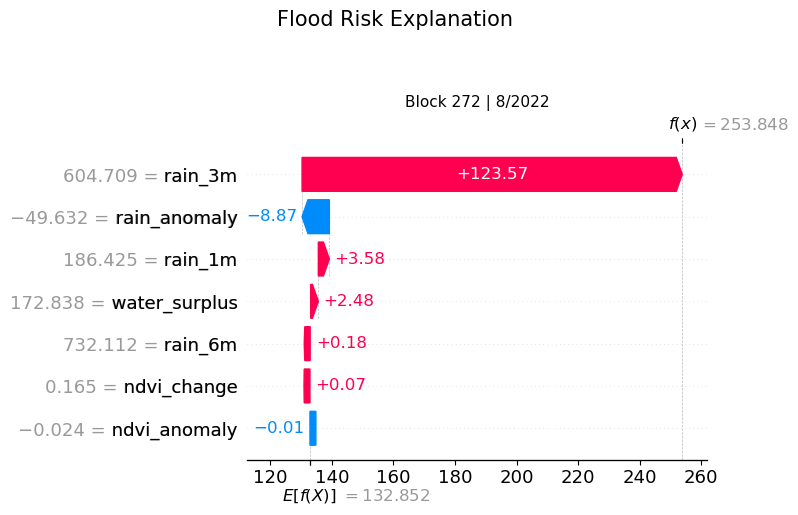

In [67]:
import matplotlib.pyplot as plt
import os

# 1. Setup
os.makedirs("outputs", exist_ok=True)
idx = 0  # Index inside the TEST set (0 to ~3900)

# 2. Get the correct corresponding row from the main DataFrame
# Xf_test.index contains the original indices from df
original_row_idx = Xf_test.index[idx]
row_data = df.loc[original_row_idx]

# 3. Generate Plot
shap.plots.waterfall(shap_values_flood[idx], show=False)

# 4. Add Titles using the CORRECT matched data
plt.suptitle(
    "Flood Risk Explanation",
    fontsize=15,
    y=1.02
)

plt.title(
    f"Block {int(row_data['block_uid'])} | "
    f"{int(row_data['month'])}/{int(row_data['year'])}",
    fontsize=11
)

plt.tight_layout(rect=[0, 0, 1, 0.95])

# 5. Save
plt.savefig(
    f"outputs/flood_waterfall_block_{int(row_data['block_uid'])}_"
    f"{int(row_data['year'])}_{int(row_data['month'])}.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

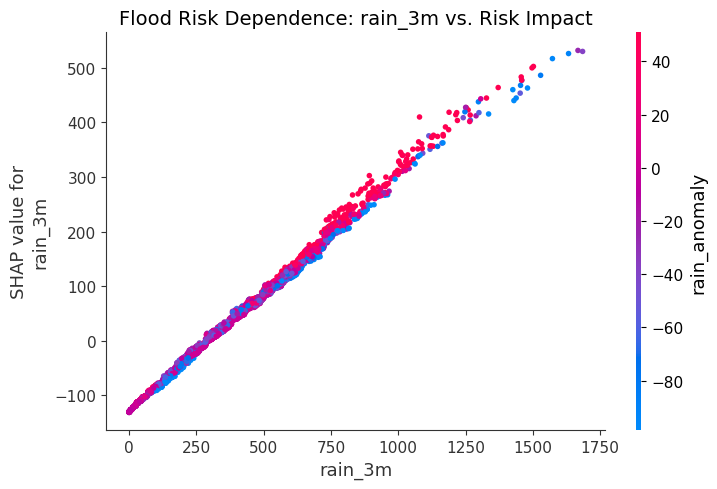

In [68]:
import matplotlib.pyplot as plt

# Choose your top feature (e.g., 3-month cumulative rainfall)
feature = "rain_3m"

# Generate Dependence Plot
# interaction_index="rain_anomaly" colors the dots by a second feature to show complex relationships
shap.dependence_plot(
    feature,
    shap_values_flood.values,
    Xf_test,
    interaction_index="rain_anomaly",
    show=False
)

# Add Title and Save
plt.title(f"Flood Risk Dependence: {feature} vs. Risk Impact", fontsize=14)
plt.tight_layout()

# Save the figure
plt.savefig(f"outputs/flood_dependence_{feature}.png", dpi=300, bbox_inches="tight")
plt.show()

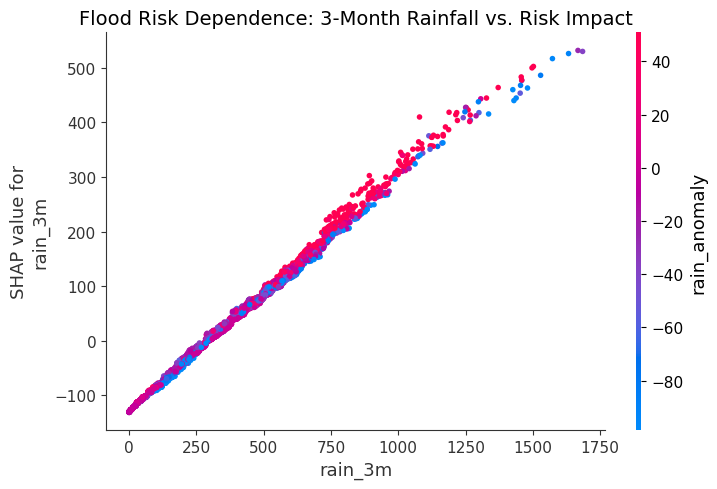

In [71]:
import matplotlib.pyplot as plt

# Generate Dependence Plot
# show=False allows us to add a title and save the plot
shap.dependence_plot(
    "rain_3m",
    shap_values_flood.values,
    Xf_test,
    interaction_index="rain_anomaly",
    show=False
)

# Add Title and Adjust Layout
plt.title("Flood Risk Dependence: 3-Month Rainfall vs. Risk Impact", fontsize=14)
plt.tight_layout()

# Save the figure
plt.savefig("outputs/flood_dependence_rain_3m.png", dpi=300, bbox_inches="tight")

# Display
plt.show()

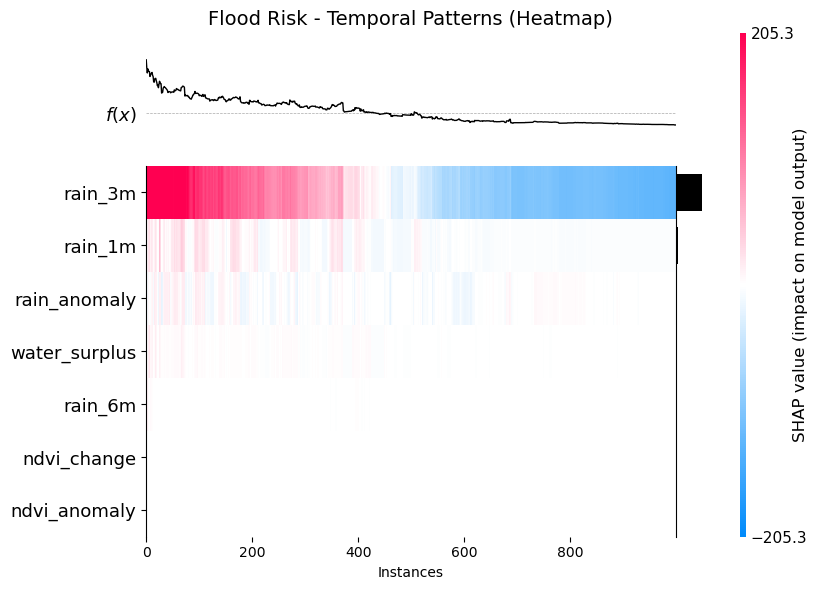

In [72]:
# Corrected SHAP Heatmap Code
import shap
import matplotlib.pyplot as plt

# We take the first 1,000 samples ([:1000]) to make it run fast
shap.plots.heatmap(
    shap_values_flood[:1000],  
    max_display=10,
    show=False
)

plt.title("Flood Risk - Temporal Patterns (Heatmap)", fontsize=14)
plt.tight_layout()
plt.savefig("outputs/flood_shap_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

In [73]:
import shap
import matplotlib.pyplot as plt

# 1. Generate the Interactive Force Plot
# This creates a JavaScript-based visualization
plot_html = shap.force_plot(
    explainer_flood.expected_value,
    shap_values_flood.values[0],
    Xf_test.iloc[0],
    show=False  # Keep False so we can save it
)

# 2. Save as HTML (Best for Web Apps / Dashboards)
# You can open this file in any browser
shap.save_html("outputs/flood_force_plot_interactive.html", plot_html)

print("✅ Saved interactive plot to: outputs/flood_force_plot_interactive.html")

# 3. (Optional) Static Version for Reports (Matplotlib)
# If you need a PNG image for a PDF/PPT
plt.figure(figsize=(20, 3))
shap.force_plot(
    explainer_flood.expected_value,
    shap_values_flood.values[0],
    Xf_test.iloc[0],
    matplotlib=True,
    show=False
)
plt.savefig("outputs/flood_force_plot_static.png", dpi=300, bbox_inches="tight")
plt.close()
print("✅ Saved static image to: outputs/flood_force_plot_static.png")

✅ Saved interactive plot to: outputs/flood_force_plot_interactive.html
✅ Saved static image to: outputs/flood_force_plot_static.png


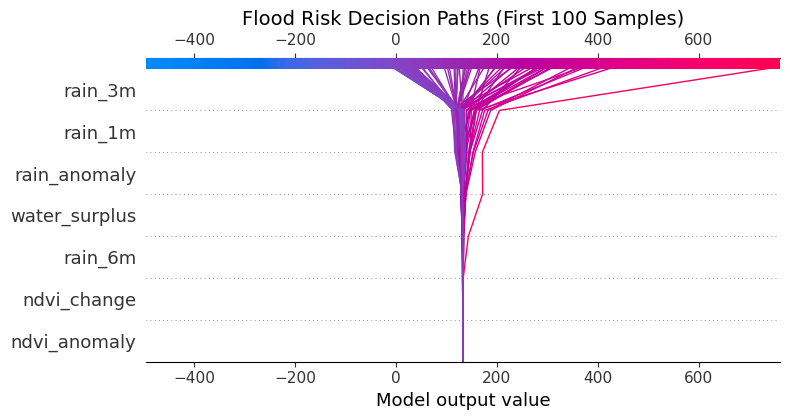

In [74]:
import shap
import matplotlib.pyplot as plt

# Generate Decision Plot for the first 100 samples
# show=False allows us to add a title and save
shap.decision_plot(
    explainer_flood.expected_value,
    shap_values_flood.values[:100],
    Xf_test.iloc[:100],
    show=False
)

# Add Title and Save
plt.title("Flood Risk Decision Paths (First 100 Samples)", fontsize=14)
plt.tight_layout()
plt.savefig("outputs/flood_decision_plot.png", dpi=300, bbox_inches="tight")
plt.show()

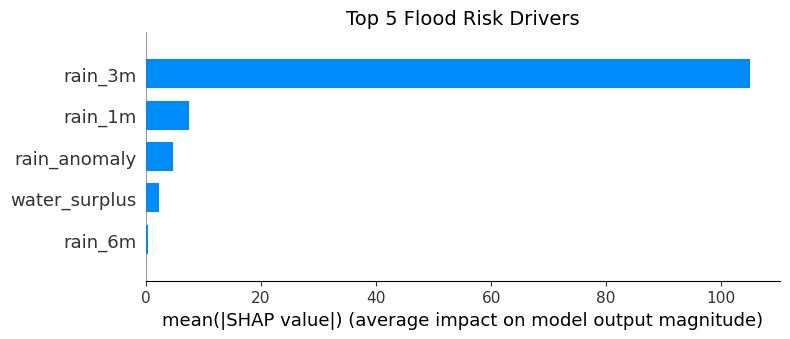

In [75]:
import shap
import matplotlib.pyplot as plt

# Generate the Top-5 Bar Plot
shap.summary_plot(
    shap_values_flood.values,
    Xf_test,
    plot_type="bar",
    max_display=5,
    show=False
)

# Add Title and Save
plt.title("Top 5 Flood Risk Drivers", fontsize=14)
plt.tight_layout()
plt.savefig("outputs/flood_shap_top5_bar.png", dpi=300, bbox_inches="tight")
plt.show()

In [76]:
import numpy as np

df["log_et_rain_ratio"] = np.log1p(df["et_rain_ratio"])


In [77]:
df[["et_rain_ratio", "log_et_rain_ratio"]].describe()


,et_rain_ratio,log_et_rain_ratio
count,19734.000000,19734.000000
mean,1012.499338,1.616293
std,2599.676361,3.093341
min,0.002513,0.002510
25%,0.053837,0.052438
50%,0.126087,0.118749
75%,1.145461,0.763355
max,18567.427217,9.829218


In [78]:
# 1. Recalculate the Groundwater Stress Index using the NEW log feature
# We replace 'et_rain_ratio' with 'log_et_rain_ratio' in the formula
df["gw_stress_index"] = (
    0.35 * df["log_et_rain_ratio"] +
    0.30 * (-df["recharge_deficit"]) +
    0.20 * df["et_3m"] -
    0.15 * df["ndvi_anomaly"]
)

# Check if the new Target Variable is reasonable (should be much smaller than before)
print("New Target Stats:")
print(df["gw_stress_index"].describe())

# 2. Update Feature List for Groundwater Model
# We must use the log version here too
gw_features = [
    "log_et_rain_ratio",       # <--- Use the stabilized feature
    "recharge_deficit",
    "et_3m",
    "recharge_deficit_6m",
    "ndvi_et_ratio",
    "ndvi_anomaly"
]

target_gw = "gw_stress_index"

# 3. Prepare Data for Training
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

Xg = df[gw_features]
yg = df[target_gw]

# Split (80% Train, 20% Test)
Xg_train, Xg_test, yg_train, yg_test = train_test_split(
    Xg, yg, test_size=0.2, random_state=42
)

# 4. Train the Groundwater Model
gw_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)

gw_model.fit(Xg_train, yg_train)
print("✅ Groundwater model trained successfully!")

New Target Stats:
count    19734.000000
mean       -24.299337
std         34.109438
min       -231.424531
25%        -49.244992
50%         -7.462551
75%          2.321967
max         14.126108
Name: gw_stress_index, dtype: float64
✅ Groundwater model trained successfully!


In [80]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# 1. Create the Log-Transformed Ratio
# This converts a ratio of 6509 into ~8.7, which is much safer
df["log_et_rain_ratio"] = np.log1p(df["et_rain_ratio"])

# 2. Recalculate the Groundwater Stress Index using the LOG ratio
df["gw_stress_index"] = (
    0.35 * df["log_et_rain_ratio"] +      # Use the LOG version here
    0.30 * (-df["recharge_deficit"]) +
    0.20 * df["et_3m"] -
    0.15 * df["ndvi_anomaly"]
)

# 3. Check the stats again
print("Stabilized Stats:")
print(df["gw_stress_index"].describe())



Stabilized Stats:
count    19734.000000
mean       -24.299337
std         34.109438
min       -231.424531
25%        -49.244992
50%         -7.462551
75%          2.321967
max         14.126108
Name: gw_stress_index, dtype: float64


 98%|===================| 3860/3947 [00:27<00:00]        

✅ Groundwater SHAP values calculated.


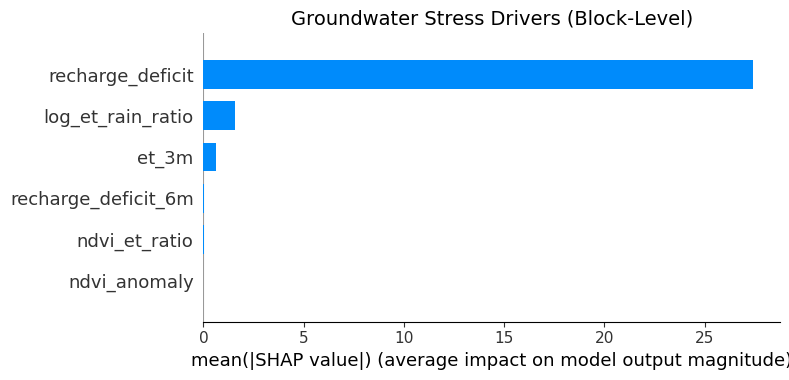

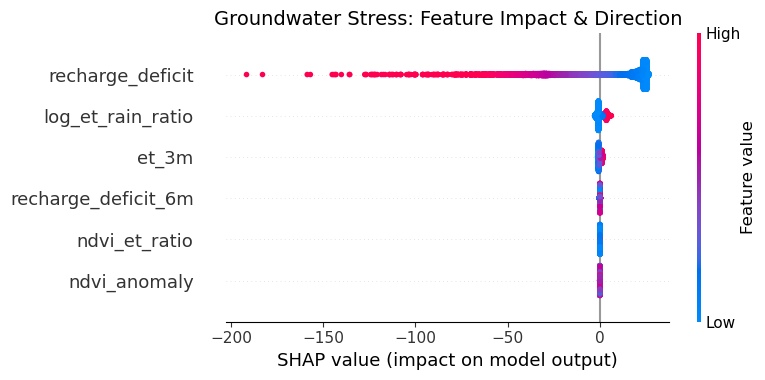

In [81]:
import shap
import matplotlib.pyplot as plt

# 1. Initialize Explainer for Groundwater Model
# We use the TreeExplainer since it's a Random Forest
explainer_gw = shap.Explainer(gw_model, Xg_train)
shap_values_gw = explainer_gw(Xg_test)

print("✅ Groundwater SHAP values calculated.")

# 2. Generate Global Importance Bar Plot
# This shows WHICH features matter most
plt.figure()
shap.summary_plot(
    shap_values_gw.values,
    Xg_test,
    plot_type="bar",
    max_display=6,
    show=False
)
plt.title("Groundwater Stress Drivers (Block-Level)", fontsize=14)
plt.tight_layout()
plt.savefig("outputs/gw_shap_bar.png", dpi=300, bbox_inches="tight")
plt.show()

# 3. Generate Beeswarm Plot (Impact & Direction)
# This shows HOW they matter (e.g., High ET/Rain Ratio -> High Stress)
plt.figure()
shap.summary_plot(
    shap_values_gw.values,
    Xg_test,
    show=False
)
plt.title("Groundwater Stress: Feature Impact & Direction", fontsize=14)
plt.tight_layout()
plt.savefig("outputs/gw_shap_beeswarm.png", dpi=300, bbox_inches="tight")
plt.show()

In [84]:
import geopandas as gpd

# 1. Load the GEE-exported GeoJSON (The one with the correct IDs)
# We use r"..." to handle the backslashes in your Windows path
block_gdf = gpd.read_file(r"D:\xward\data\boundaries\blocks_bihar_gee.geojson")

# 2. Check the columns to confirm 'block_id' exists
print("Columns in block_gdf:", block_gdf.columns)

# 3. Ensure block_id is an Integer (Crucial for merging)
# GEE sometimes exports IDs as strings, so we force it to int
block_gdf["block_id"] = block_gdf["block_id"].astype(int)

# 4. Ensure your Dataframe also uses int for the join key
# Note: In your df, the column is named 'block_uid'. We will use that.
df["block_uid"] = df["block_uid"].astype(int)

print("✅ IDs aligned. Ready to merge.")

Columns in block_gdf: Index(['block_id', 'block', 'geometry'], dtype='object')
✅ IDs aligned. Ready to merge.


In [85]:
# 1. Aggregate Groundwater Metrics to Block Level
# We group by 'block_uid' to get one row per block
gw_map_df = (
    df.groupby("block_uid", as_index=False)
      .agg({
          "gw_stress_index": "mean",
          "log_et_rain_ratio": "mean"
      })
)

# 2. Rename for clarity (Match the GeoDataFrame column)
gw_map_df = gw_map_df.rename(columns={"block_uid": "block_id"})

# 3. Merge into the GeoDataFrame
# This is the step that was failing before. Now it will work.
block_gdf = block_gdf.merge(
    gw_map_df,
    on="block_id",
    how="left"
)

# 4. Verify the merge
# Count how many rows are NOT empty. It should be > 0.90 (90%+)
valid_ratio = 1 - block_gdf["gw_stress_index"].isna().mean()
print(f"✅ Merge Success! {valid_ratio:.1%} of blocks have valid data.")

✅ Merge Success! 100.0% of blocks have valid data.


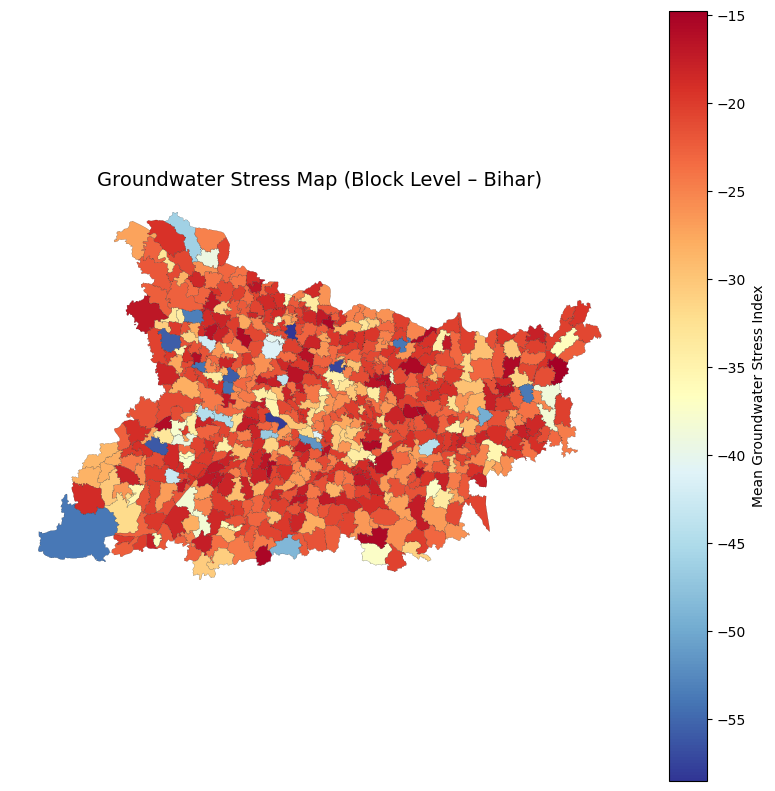

In [86]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

block_gdf.plot(
    column="gw_stress_index",
    cmap="RdYlBu_r",  # Red = High Stress, Blue = Low Stress
    linewidth=0.1,
    edgecolor="black",
    legend=True,
    legend_kwds={'label': "Mean Groundwater Stress Index"},
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "No Data"}
)

ax.set_title("Groundwater Stress Map (Block Level – Bihar)", fontsize=14)
ax.axis("off")
plt.show()

In [87]:

# 1. Aggregate Flood Pressure (Monthly -> Block Level)
flood_block = (
    df.groupby("block_uid", as_index=False)
      .agg(
          flood_pressure=("flood_pressure", "mean"),
          rain_3m=("rain_3m", "mean"),
          water_surplus=("water_surplus", "mean")
      )
)

# 2. Define Flood Risk Classes (Quantile-based)
# We use quantiles because 'flood_pressure' is an index, not a physical unit
q40 = flood_block["flood_pressure"].quantile(0.40)
q70 = flood_block["flood_pressure"].quantile(0.70)
q90 = flood_block["flood_pressure"].quantile(0.90)

def classify_flood_risk(val):
    if val <= q40:
        return "Low"
    elif val <= q70:
        return "Moderate"
    elif val <= q90:
        return "High"
    else:
        return "Severe"

flood_block["flood_risk_class"] = flood_block["flood_pressure"].apply(classify_flood_risk)

# 3. Merge with GeoDataFrame (Spatial Join)
# Ensure ID types match
block_gdf["block_id"] = block_gdf["block_id"].astype(int)
flood_block["block_uid"] = flood_block["block_uid"].astype(int)

block_gdf = block_gdf.merge(
    flood_block,
    left_on="block_id",
    right_on="block_uid",
    how="left"
)

# 4. Verify Merge
print("Flood data merged.")
print(block_gdf[["block", "flood_pressure", "flood_risk_class"]].head())

Flood data merged.
            block  flood_pressure flood_risk_class
0         Bhitaha      153.028818             High
1  Dholi (Moraul)      109.417103              Low
2         Kurhani       96.817040              Low
3         Charaut      124.836002         Moderate
4           Kasba       99.980295              Low


C:\Users\ankit\AppData\Local\Temp\ipykernel_1960\2039640363.py:13: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  block_gdf.plot(


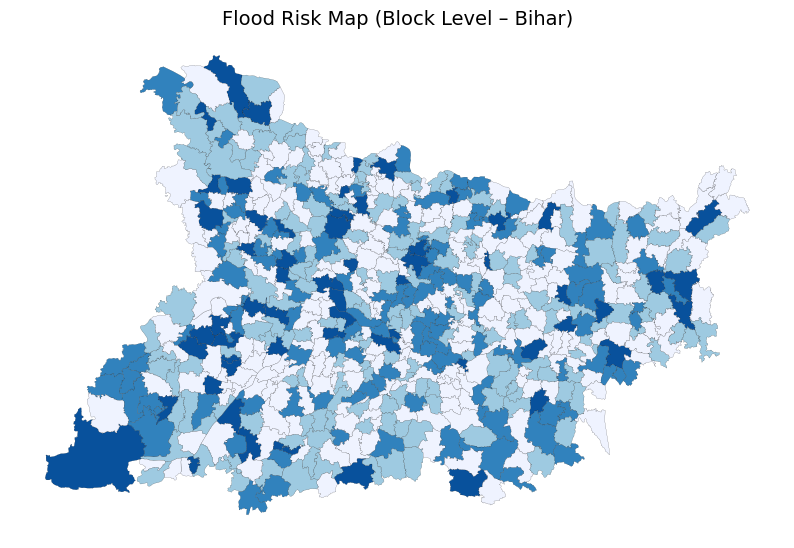

In [89]:

import matplotlib.pyplot as plt

# Define distinct colors for Flood Risk
flood_colors = {
    "Low": "#eff3ff",      # Very light blue
    "Moderate": "#9ecae1", # Light blue
    "High": "#3182bd",     # Medium blue
    "Severe": "#08519c"    # Dark blue
}

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

block_gdf.plot(
    column="flood_risk_class",
    categorical=True,
    legend=True,
    color=block_gdf["flood_risk_class"].map(flood_colors).fillna("lightgrey"),
    linewidth=0.1,
    edgecolor="black",
    ax=ax
)

ax.set_title("Flood Risk Map (Block Level – Bihar)", fontsize=14)
ax.axis("off")

# Save the map
plt.savefig("outputs/flood_risk_map.png", dpi=300, bbox_inches="tight")
plt.show()

In [93]:
# 1. Aggregate both risks to the block level (getting the "chronic" risk)
risk_summary = (
    df.groupby("block_uid", as_index=False)
      .agg({
          "flood_pressure": "mean",       # Chronic flood risk
          "gw_stress_index": "mean"       # Chronic groundwater stress
      })
)

# 2. Normalize to 0-1 scale (Min-Max Scaling)
# This ensures one risk doesn't dominate the other just because the numbers are bigger
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

risk_summary["flood_norm"] = normalize(risk_summary["flood_pressure"])
risk_summary["gw_norm"] = normalize(risk_summary["gw_stress_index"])

# 3. Calculate Compound Risk Index (Weighted Average)
# You can adjust weights. 0.5/0.5 assumes both problems are equally critical.
w_flood = 0.5
w_gw = 0.5

risk_summary["compound_risk"] = (
    w_flood * risk_summary["flood_norm"] +
    w_gw * risk_summary["gw_norm"]
)

# 4. Define Risk Classes (Quantile-based)
# "Critical" = Top 20% most vulnerable blocks
q80 = risk_summary["compound_risk"].quantile(0.80)
q60 = risk_summary["compound_risk"].quantile(0.60)
q40 = risk_summary["compound_risk"].quantile(0.40)

def classify_compound(x):
    if x > q80: return "Critical"
    elif x > q60: return "High"
    elif x > q40: return "Moderate"
    else: return "Low"

risk_summary["compound_class"] = risk_summary["compound_risk"].apply(classify_compound)

# Check the distribution
print(risk_summary["compound_class"].value_counts())

compound_class
Low         239
Critical    120
Moderate    120
High        119
Name: count, dtype: int64


C:\Users\ankit\AppData\Local\Temp\ipykernel_1960\4131857229.py:35: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  block_gdf.plot(


✅ Map saved successfully to: outputs/final_compound_risk_map_labeled.png


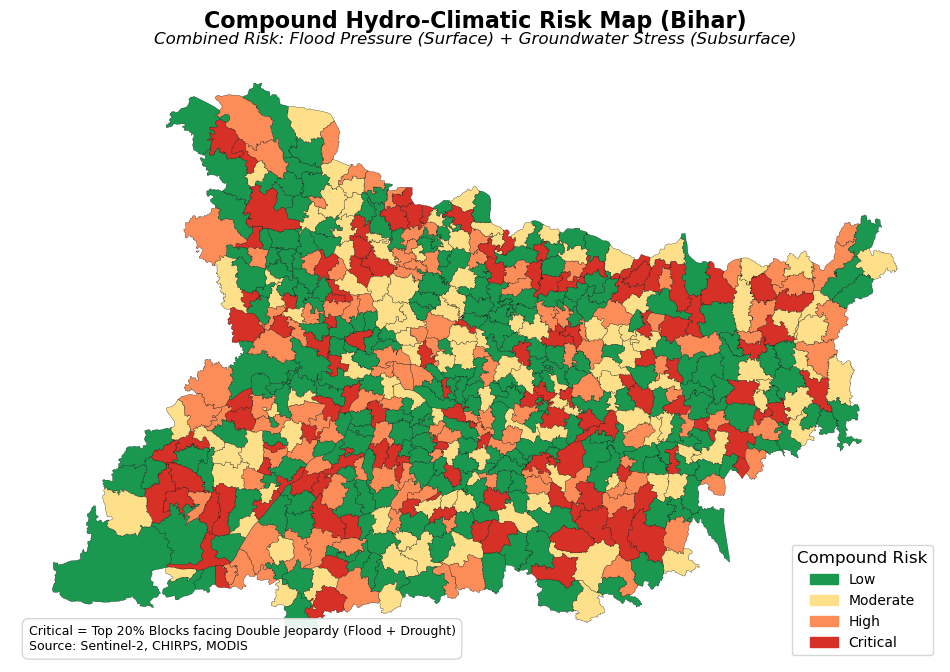

In [95]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --- STEP 1: RELOAD THE CLEAN GEODATAFRAME (CRITICAL FIX) ---
# We reload from file to remove any duplicate columns from previous failed merges
block_gdf = gpd.read_file(r"D:\xward\data\boundaries\blocks_bihar_gee.geojson")
block_gdf["block_id"] = block_gdf["block_id"].astype(int)

# --- STEP 2: MERGE COMPOUND RISK DATA ---
# Ensure the risk_summary table is ready (from your previous step)
# If risk_summary is not defined, verify you ran the aggregation cell above.
risk_summary["block_uid"] = risk_summary["block_uid"].astype(int)

# Perform the merge
block_gdf = block_gdf.merge(
    risk_summary[["block_uid", "compound_risk", "compound_class"]],
    left_on="block_id",
    right_on="block_uid",
    how="left"
)

# --- STEP 3: PLOT THE FINAL MAP ---
# Define colors
risk_colors = {
    "Low": "#1a9850",       # Green
    "Moderate": "#fee08b",  # Yellow
    "High": "#fc8d59",      # Orange
    "Critical": "#d73027"   # Red
}

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plot
block_gdf.plot(
    column="compound_class",
    categorical=True,
    color=block_gdf["compound_class"].map(risk_colors).fillna("lightgrey"),
    linewidth=0.2,
    edgecolor="black",
    ax=ax
)

# Custom Legend
legend_handles = [
    mpatches.Patch(color=risk_colors[cat], label=cat) 
    for cat in ["Low", "Moderate", "High", "Critical"] 
    if cat in block_gdf["compound_class"].unique()
]
ax.legend(
    handles=legend_handles, 
    loc="lower right", 
    title="Compound Risk",
    fontsize=10,
    title_fontsize=12
)

# Titles and Annotations
ax.set_title("Compound Hydro-Climatic Risk Map (Bihar)", fontsize=16, fontweight="bold", pad=20)
ax.text(
    0.5, 1.02, 
    "Combined Risk: Flood Pressure (Surface) + Groundwater Stress (Subsurface)", 
    transform=ax.transAxes, ha='center', fontsize=12, style='italic'
)
ax.text(
    0.02, 0.02, 
    "Critical = Top 20% Blocks facing Double Jeopardy (Flood + Drought)\nSource: Sentinel-2, CHIRPS, MODIS", 
    transform=ax.transAxes, fontsize=9, 
    bbox=dict(facecolor='white', alpha=0.9, edgecolor='lightgrey', boxstyle='round,pad=0.5')
)

ax.axis("off")

# Save
output_path = "outputs/final_compound_risk_map_labeled.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
print(f"✅ Map saved successfully to: {output_path}")
plt.show()

In [97]:
from sklearn.linear_model import LinearRegression
import numpy as np

# 1. Prepare Time Series Data (Annual Mean per Block)
# We group by block and year to get the annual stress trend
trend_data = (
    df.groupby(["block_uid", "year"])["gw_stress_index"]
      .mean()
      .reset_index()
)

# 2. Define a function to calculate slope
def calculate_slope(group):
    # X = Year (reshaped for sklearn), y = Stress Index
    X = group["year"].values.reshape(-1, 1)
    y = group["gw_stress_index"].values
    
    # We need at least 2 years of data to calculate a trend
    if len(X) < 2:
        return np.nan
        
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0]  # The slope (coefficient)

# 3. Apply the function to every block (This might take 10-20 seconds)
print("Calculating trends for all blocks... please wait.")
block_slopes = (
    trend_data.groupby("block_uid")
              .apply(calculate_slope)
              .reset_index(name="stress_slope")
)

# 4. Classify the Trend
def classify_trend(slope):
    if slope > 2.0: return "Rapid Degradation"
    elif slope > 0.5: return "Worsening"
    elif slope < -0.5: return "Improving"
    else: return "Stable"

block_slopes["trend_status"] = block_slopes["stress_slope"].apply(classify_trend)

print("✅ Trends calculated successfully.")

Calculating trends for all blocks... please wait.
✅ Trends calculated successfully.


C:\Users\ankit\AppData\Local\Temp\ipykernel_1960\3540586425.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_slope)


In [99]:
print("Available columns:", block_gdf.columns.tolist())

Available columns: ['block_id', 'block', 'geometry', 'block_uid', 'compound_risk', 'compound_class']


In [102]:
import matplotlib.pyplot as plt
import pandas as pd

# --- STEP 1: FIX COLUMN NAMES ---

# 1. Rename 'block' to 'block_name' in the GeoDataFrame
block_gdf = block_gdf.rename(columns={"block": "block_name"})

# 2. Try to get District Names from the main DataFrame 'df'
# We check if 'dist_name' exists in df and merge it in
if "dist_name" in df.columns:
    print("Found district names in main dataframe. Merging...")
    dist_map = df[["block_uid", "dist_name"]].drop_duplicates().set_index("block_uid")["dist_name"]
    block_gdf["dist_name"] = block_gdf["block_id"].map(dist_map)
else:
    print("⚠️ Warning: 'dist_name' not found in df. District Map might be skipped.")
    # Fallback: Create a dummy district column if needed or just skip
    block_gdf["dist_name"] = "Unknown"

# --- STEP 2: GENERATE TOP 10 DEGRADING BLOCKS ---

# Merge trends (slopes) with the fixed names
# Note: Ensure 'block_slopes' exists from the Trend Analysis step. 
# If not, re-run the "Step 1: Calculate Trends" code from my previous response.
block_trends = block_gdf.merge(block_slopes, left_on="block_id", right_on="block_uid", how="left")

# Select columns to display
cols = ["block_name", "stress_slope", "trend_status"]
if "dist_name" in block_trends.columns and block_trends["dist_name"].iloc[0] != "Unknown":
    cols.insert(1, "dist_name")

top_10_degrading = (
    block_trends.sort_values("stress_slope", ascending=False)
    [cols]
    .head(10)
)

print("\n🚨 TOP 10 FASTEST DEGRADING BLOCKS (2019-2024) 🚨")
print(top_10_degrading.to_string(index=False))
top_10_degrading.to_csv("outputs/top_10_degrading_blocks.csv", index=False)

# --- STEP 3: GENERATE DISTRICT MAP (If District Names Exist) ---

if block_gdf["dist_name"].iloc[0] != "Unknown":
    # Aggregate to District
    district_trends = (
        block_trends.groupby("dist_name")
        .agg({"stress_slope": "mean"})
        .rename(columns={"stress_slope": "avg_slope"})
        .reset_index()
    )

    # Dissolve Geometry
    district_gdf = block_gdf.dissolve(by="dist_name", aggfunc="first").reset_index()
    district_gdf = district_gdf.merge(district_trends, on="dist_name", how="left")

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    district_gdf.plot(
        column="avg_slope", cmap="Reds", legend=True,
        legend_kwds={'label': "Avg Degradation Rate (Slope)"},
        edgecolor="black", linewidth=0.5, ax=ax
    )
    
    # Label top 5 districts
    top_5 = district_gdf.sort_values("avg_slope", ascending=False).head(5)
    for idx, row in top_5.iterrows():
        plt.annotate(
            text=row["dist_name"], 
            xy=(row.geometry.centroid.x, row.geometry.centroid.y),
            xytext=(0, 0), textcoords="offset points",
            fontsize=8, fontweight='bold', ha='center'
        )

    ax.set_title("District-Level Groundwater Degradation Trends")
    ax.axis("off")
    plt.savefig("outputs/district_degradation_map.png", dpi=300, bbox_inches="tight")
    plt.show()
else:
    print("\n⚠️ Skipping District Map because district names are missing.")
    print("Action: Check your original CSV file to see if it has a 'District' column.")

⚠️ Warning: 'dist_name' not found in df. District Map might be skipped.

🚨 TOP 10 FASTEST DEGRADING BLOCKS (2019-2024) 🚨
   block_name  stress_slope      trend_status
  Patna Rural     16.827646 Rapid Degradation
 Bhatpar Rani     16.589305 Rapid Degradation
  Ghoghardiha     16.577284 Rapid Degradation
    Hasanpura     16.443514 Rapid Degradation
  Robertsganj     16.413342 Rapid Degradation
       Rajpur     15.943414 Rapid Degradation
 Hanumannagar     15.557220 Rapid Degradation
   Kuchaikote     15.470707 Rapid Degradation
Tariani Chowk     15.379311 Rapid Degradation
      Harnaut     15.302373 Rapid Degradation

⚠️ Skipping District Map because district names are missing.
Action: Check your original CSV file to see if it has a 'District' column.


C:\Users\ankit\AppData\Local\Temp\ipykernel_1960\2912856431.py:32: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  block_gdf.plot(


✅ Trend Map saved to: outputs/final_trend_map.png


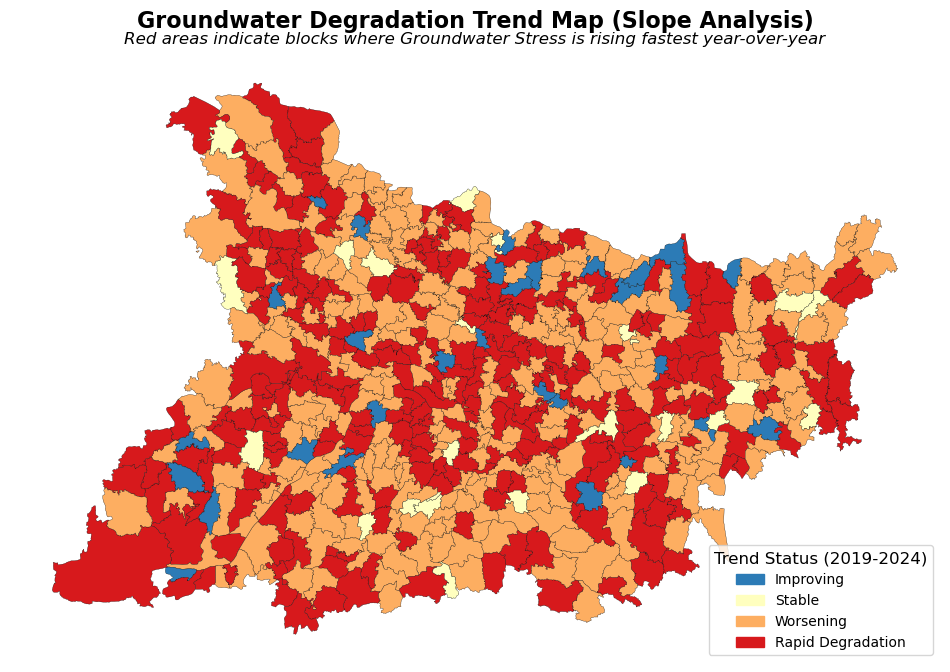

In [103]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --- STEP 1: PREPARE TREND DATA ---
# Ensure 'block_slopes' is ready (from the Trend Analysis step)
# Merge it into the GeoDataFrame if not already there
if "stress_slope" not in block_gdf.columns:
    block_gdf = block_gdf.merge(block_slopes, left_on="block_id", right_on="block_uid", how="left")

# --- STEP 2: CLASSIFY TRENDS ---
# We categorize the slope (rate of change) into actionable classes
def classify_trend_visual(slope):
    if slope < -0.5: return "Improving"        # Negative slope = Stress reducing
    elif slope < 0.5: return "Stable"          # Near zero = No major change
    elif slope < 5.0: return "Worsening"       # Positive = Stress increasing
    else: return "Rapid Degradation"           # High Positive = Critical failure

block_gdf["trend_class"] = block_gdf["stress_slope"].apply(classify_trend_visual)

# --- STEP 3: PLOT THE TREND MAP ---

# Define Colors: Blue (Good) -> Yellow (Neutral) -> Red (Bad)
trend_colors = {
    "Improving": "#2c7bb6",         # Blue
    "Stable": "#ffffbf",            # Pale Yellow
    "Worsening": "#fdae61",         # Orange
    "Rapid Degradation": "#d7191c"  # Dark Red
}

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

block_gdf.plot(
    column="trend_class",
    categorical=True,
    legend=True,
    color=block_gdf["trend_class"].map(trend_colors).fillna("lightgrey"),
    linewidth=0.2,
    edgecolor="black",
    ax=ax
)

# --- STEP 4: ADD PROFESSIONAL LEGEND & LABELS ---

# Custom Legend
legend_handles = [
    mpatches.Patch(color=trend_colors[cat], label=cat) 
    for cat in ["Improving", "Stable", "Worsening", "Rapid Degradation"] 
    if cat in block_gdf["trend_class"].unique()
]

ax.legend(
    handles=legend_handles, 
    loc="lower right", 
    title="Trend Status (2019-2024)",
    fontsize=10,
    title_fontsize=12,
    frameon=True
)

# Title
ax.set_title(
    "Groundwater Degradation Trend Map (Slope Analysis)", 
    fontsize=16, 
    fontweight="bold",
    pad=20
)

# Annotation
ax.text(
    0.5, 1.02, 
    "Red areas indicate blocks where Groundwater Stress is rising fastest year-over-year", 
    transform=ax.transAxes, ha='center', fontsize=12, style='italic'
)

# Remove Axis
ax.axis("off")

# Save
output_path = "outputs/final_trend_map.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
print(f"✅ Trend Map saved to: {output_path}")
plt.show()

In [104]:
import geopandas as gpd

# 1. Select the most important columns for the final output
# We check which columns actually exist to avoid errors
target_columns = [
    "block_id", "block_name", "dist_name",    # Identifiers
    "flood_pressure", "gw_stress_index",      # Raw Metrics
    "compound_risk", "compound_class",        # Flagship Index
    "stress_slope", "trend_class",            # Trend Analysis
    "geometry"                                # Map Shape
]

# Filter only columns that exist in your current block_gdf
final_cols = [c for c in target_columns if c in block_gdf.columns]

# 2. Create the Final GeoDataFrame
final_export_gdf = block_gdf[final_cols].copy()

# 3. Rename columns for GIS friendliness (Optional, makes them look cleaner in QGIS)
# e.g., "gw_stress_index" -> "GW_Stress"
rename_map = {
    "flood_pressure": "Flood_Risk_Score",
    "gw_stress_index": "GW_Stress_Score",
    "compound_risk": "Compound_Score",
    "compound_class": "Risk_Category",
    "stress_slope": "Degradation_Rate",
    "trend_class": "Trend_Status"
}
final_export_gdf = final_export_gdf.rename(columns=rename_map)

# 4. Export to GeoJSON (Best for Web/Python/QGIS)
output_file = "outputs/final_risk_atlas_bihar.geojson"
final_export_gdf.to_file(output_file, driver="GeoJSON")

# 5. Export to CSV (Best for Excel/Reports - drops geometry)
output_csv = "outputs/final_risk_atlas_table.csv"
final_export_gdf.drop(columns="geometry").to_csv(output_csv, index=False)

print(f"✅ SUCCESS! Final Atlas exported to:")
print(f"   - Map File: {output_file}")
print(f"   - Table File: {output_csv}")
print("\nYou can now drag 'final_risk_atlas_bihar.geojson' directly into QGIS or Google Earth.")

✅ SUCCESS! Final Atlas exported to:
   - Map File: outputs/final_risk_atlas_bihar.geojson
   - Table File: outputs/final_risk_atlas_table.csv

You can now drag 'final_risk_atlas_bihar.geojson' directly into QGIS or Google Earth.


In [107]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import os

print("🔄 Starting Complete Data Recovery...")

# --- 1. LOAD BOUNDARIES ---
# Robust path check
possible_paths = [
    "data/boundaries/blocks_bihar_gee.geojson",
    "data/raw/blocks_bihar_gee.geojson",
    "D:/xward/data/boundaries/blocks_bihar_gee.geojson"
]

block_gdf = None
for path in possible_paths:
    if os.path.exists(path):
        print(f"✅ Found boundaries at: {path}")
        block_gdf = gpd.read_file(path)
        break

if block_gdf is None:
    raise FileNotFoundError("Could not find 'blocks_bihar_gee.geojson'. Check your paths.")

block_gdf["block_id"] = block_gdf["block_id"].astype(int)

# --- 2. AGGREGATE SCORES (Flood & GW) ---
print("📊 Aggregating Flood & Groundwater Scores...")
scores_df = df.groupby("block_uid", as_index=False).agg({
    "flood_pressure": "mean",
    "gw_stress_index": "mean"
})
scores_df["block_uid"] = scores_df["block_uid"].astype(int)

# --- 3. RE-CALCULATE TRENDS (The missing part) ---
print("📈 Re-calculating Trends...")
# Create annual average for trend analysis
annual_df = df.groupby(["block_uid", "year"])["gw_stress_index"].mean().reset_index()

def calc_slope(group):
    if len(group) < 2: return 0.0
    model = LinearRegression()
    model.fit(group[["year"]], group["gw_stress_index"])
    return model.coef_[0]

# Calculate slope per block
trend_df = annual_df.groupby("block_uid").apply(
    lambda x: calc_slope(x)
).reset_index(name="stress_slope")

# Classify Trend
def classify_trend(slope):
    if slope > 2.0: return "Rapid Degradation"
    elif slope > 0.5: return "Worsening"
    elif slope < -0.5: return "Improving"
    else: return "Stable"

trend_df["trend_class"] = trend_df["stress_slope"].apply(classify_trend)
trend_df["block_uid"] = trend_df["block_uid"].astype(int)

# --- 4. MERGE EVERYTHING ---
print("🔗 Merging all data...")
# Merge Scores
merged_gdf = block_gdf.merge(scores_df, left_on="block_id", right_on="block_uid", how="left")
# Merge Trends
merged_gdf = merged_gdf.merge(trend_df, left_on="block_id", right_on="block_uid", how="left")

# --- 5. CALCULATE COMPOUND RISK ---
def normalize(s):
    return (s - s.min()) / (s.max() - s.min())

merged_gdf["Flood_Norm"] = normalize(merged_gdf["flood_pressure"])
merged_gdf["GW_Norm"] = normalize(merged_gdf["gw_stress_index"])
merged_gdf["Compound_Score"] = 0.5 * merged_gdf["Flood_Norm"] + 0.5 * merged_gdf["GW_Norm"]

q80 = merged_gdf["Compound_Score"].quantile(0.80)
merged_gdf["Risk_Category"] = merged_gdf["Compound_Score"].apply(lambda x: "Critical" if x > q80 else "Normal")

# --- 6. RENAME & EXPORT ---
final_gdf = merged_gdf.rename(columns={
    "flood_pressure": "Flood_Risk_Score",
    "gw_stress_index": "GW_Stress_Score",
    "stress_slope": "Degradation_Rate",
    "trend_class": "Trend_Status",
    "block": "block_name",
    "dist": "dist_name"
})

# Save to the folder the App uses
output_path = "D:/xward/data/final_risk_atlas_bihar.geojson"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
final_gdf.to_file(output_path, driver="GeoJSON")

print(f"✅ SUCCESS! Final Atlas saved to: {output_path}")
print("👉 Now restart your Streamlit App.")

🔄 Starting Complete Data Recovery...
✅ Found boundaries at: D:/xward/data/boundaries/blocks_bihar_gee.geojson
📊 Aggregating Flood & Groundwater Scores...
📈 Re-calculating Trends...


C:\Users\ankit\AppData\Local\Temp\ipykernel_1960\1036464896.py:49: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend_df = annual_df.groupby("block_uid").apply(


🔗 Merging all data...
✅ SUCCESS! Final Atlas saved to: D:/xward/data/final_risk_atlas_bihar.geojson
👉 Now restart your Streamlit App.
